In [ ]:
#| default_exp wh_transcribe

## Precompute Whisper transcriptions for VQ bottleneck distilation

Doing transcription means sampling from the Whisper auto-regresive decoder. This is too slow to do for each training batch. Fortunately the trainscriptions are small text snippets so we can precompute them once for the whole dataset.

We use segments from Voice Activity Detection to reduce any boundary issues, the we use webdataset to yields multiple chunks from a FLAC file we only load once. The VAD segments are merged into longer chunks to make Whisper processing more efficent (it always processes 30s at a time)

**Usage:**  
```
python -m whisperspeech.wh_transcribe librilight-large-wo6454-flac-000002.tar
```

You can pass in either a URL or a local file name. Either way it will expect a `vad` file in the local directory. The result will go into a file in the current directory named after the source file but replacing `flac` with `txt`.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import io
import time
import torch
import torchaudio

In [ ]:
#| export
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import numpy as np
import random

import whisper

from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

from fastcore.script import *

from whisperspeech import vad
import webdataset as wds

In [ ]:
import pylab as plt
import IPython

In [ ]:
flac_url = 'https://huggingface.co/datasets/collabora/librilight-webdataset/resolve/main/librilight-small-flac-000000.tar'

In [ ]:
flac_url = './librilight-small-flac-000000.tar'

## Merge VAD segments into longer chunks

In [ ]:
#| exporti
# let's make it a bit more conservative
# with full 30 second chunks it sometimes misses a small part of the transcript
def random_cutter(dur):
    if random.random() < 0.5:
        return dur > 28 * (random.random()*0.95+0.05)
    else:
        return dur > 28

def chunk_merger(segments, should_cut=lambda x: x > 28):
    curr_start = segments[0][0]
    curr_end = 0
    merged = []

    for ts,te in segments:
        if should_cut(te - curr_start) and curr_end - curr_start > 0:
            merged.append((curr_start, curr_end))
            curr_start = ts
        curr_end = te
    merged.append((curr_start, curr_end))
    return merged

In [ ]:
# load some VAD ouputs
ds = wds.WebDataset(
    vad.flac_to_vad_name(flac_url)
).decode().to_tuple('vad.npy')
chunks = [x[0] for x in progress_bar(ds, total='noinfer')]

In [ ]:
# quick test
len(chunks[0]), len(chunk_merger(chunks[0]))

(46, 28)

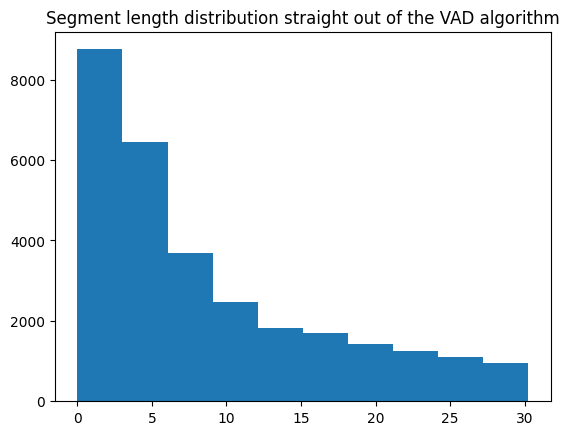

In [ ]:
plt.hist([te-ts for x in chunks for ts,te in x])
plt.title('Segment length distribution straight out of the VAD algorithm');

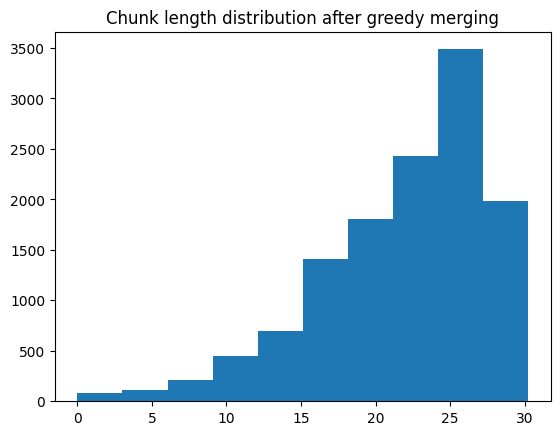

In [ ]:
plt.hist([te-ts for x in chunks for ts,te in chunk_merger(x)]);
plt.title('Chunk length distribution after greedy merging');

In [ ]:
(np.array([te-ts for x in chunks for ts,te in chunk_merger(x)]) < 10).mean()

0.03671825647504738

In the above distribution only 3,7% of the samples have < 10 seconds. We noticed that this limits the ability of the T2S model to generate short sequences reliably.

It does not seem to matter for quantizing Whisper so we can keep this distribution (it uses less compute for training).

For T2S we can add some more shorter chunks at random:

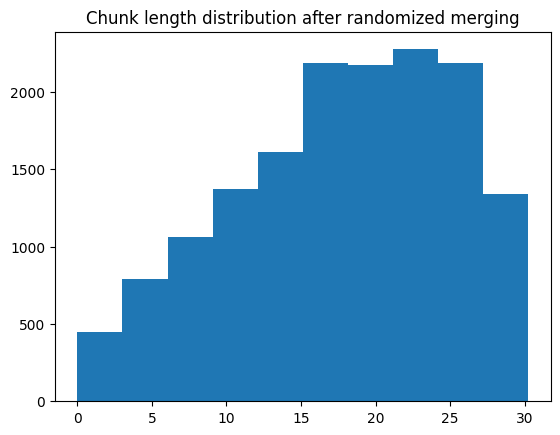

In [ ]:
plt.hist([te-ts for x in chunks for ts,te in chunk_merger(x, random_cutter)])
plt.title('Chunk length distribution after randomized merging');

## Merge the FLAC and VAD datasets

First we want to merge the VAD dataset with the FLAC audio data.

In [ ]:
#| exporti
def merge_in(*datasets):
    """Merge multiple datasets into the current one returning samples with the union of keys.
    
    It requires (and validates) all datasets to have the same ordering of keys so you have
    to use it before any sample shuffling. Shard shuffling is ok.
    """
    def merge_loop(main_samples):
        for samples in zip(*[main_samples]+[iter(x) for x in datasets]):
            key = samples[0]['__key__']
            news = {}
            for s in samples:
                assert s['__key__'] == key
                news.update(s)
            yield news
    return merge_loop

In [ ]:
#| exporti
import copy

In [ ]:
#| exporti
# a workaround for https://github.com/webdataset/webdataset/issues/297
# should be possible to use ds.compose here
def wds_compose(ds, *args):
    ds = copy.copy(ds)
    ds.pipeline = copy.copy(ds.pipeline)
    for f in args:
        ds.append(f)
    return ds

In [ ]:
ds = wds_compose(vad.load_dataset(flac_url),
    merge_in(wds.WebDataset(vad.flac_to_vad_name(flac_url)).decode())
)

In [ ]:
for s in ds: break
s # notice the 'vad.npy' values that was missing from the FLAC dataset

{'__key__': 'small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb',
 '__url__': 'librilight-small-vad-000000.tar.gz',
 'flac': (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 16000),
 'json': {'speaker': '100',
  'book_meta': {'id': '2315',
   'title': 'Sea Fairies',
   'description': "<p>In 1910, Baum hoped to end the Oz series and follow with a new series about a little girl named Trot and her sailor companion, Cap'n Bill. The Sea Fairies (1911) was the first book in the projected series and took Trot and Cap'n Bill under the sea where they had adventures with mermaids and other fantastic creatures. It was followed by Sky Island (1912) and then Baum returned to the Oz titles. He brought Trot and Cap'n Bill to Oz in the Scarecrow of Oz (1915). (Summary by Judy Bieber)</p>",
   'url_text_source': 'http://www.gutenberg.org/etext/4358',
   'language': 'English',
   'copyright_year': '1911',
   'num_sections': '22',
   'url_rss': 'https://librivox.org/rss/2315',
   'url_zip_fi

## Split the audio into chunks

After we merge the datasets and chunk the segments we can split each audio file into individual samples and pad them to 30s.

In [ ]:
#| exporti
def split_to_chunks(stream, pad_to_seconds=30, random_shift=False):
    for s in stream:
        audio, sr = s['flac']
        imax = len(s['vad.npy']) - 1
        for i,(ts,te) in enumerate(s['vad.npy']):
            samples = audio[0,int(ts*sr):int(te*sr)]
            padding = pad_to_seconds*sr-samples.shape[-1]
            lpad = random.randint(0, padding) if random_shift else 0
            yield {"__key__": s['__key__'] + f"_{i:03d}",
                   "__url__": s['__url__'],
                   "i": i, "imax": imax,
                   "tstart": ts, "tend": te, "total_seconds": audio.shape[-1]/sr,
                   "samples": F.pad(samples, (lpad, padding-lpad))}

In [ ]:
split_ds = wds_compose(ds,
   wds.map_dict(**{"vad.npy":chunk_merger}),
   split_to_chunks,
)

In [ ]:
for s in split_ds: break
s

{'__key__': 'small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_000',
 '__url__': 'librilight-small-vad-000000.tar.gz',
 'i': 0,
 'imax': 27,
 'tstart': 1.764,
 'tend': 14.03,
 'total_seconds': 597.9425,
 'samples': tensor([0., 0., 0.,  ..., 0., 0., 0.])}

## Transcribe

In [ ]:
whmodel = whisper.load_model('base.en')
decoding_options = whisper.DecodingOptions(language='en')

In [ ]:
output = flac_url.rsplit("/", 1)[1].replace('flac', 'txt') + ".gz"
with wds.TarWriter(output) as sink:
    for s in progress_bar(split_ds, total=256):
        mel = whisper.log_mel_spectrogram(s['samples'].unsqueeze(0).cuda())
        embs = whmodel.encoder(mel)
        decs = whmodel.decode(embs, decoding_options)

        sink.write({
            "__key__": s['__key__'],
            "txt": decs[0].text,
        })

## Transcribe in batches

We have one more thing to add – batch processing makes the transcription quite a bit faster (bs=16 brings a 4.5x speedup).

In [ ]:
batched_ds = wds_compose(split_ds,
    wds.to_tuple('__key__', 'samples'),
    wds.batched(16),
)

In [ ]:
output = flac_url.rsplit("/", 1)[1].replace('flac', 'txt') + ".gz"
with wds.TarWriter(output) as sink:
    for keys, samples in progress_bar(batched_ds, total=256//16):
        mel = whisper.log_mel_spectrogram(samples).cuda()
        embs = whmodel.encoder(mel)
        decs = whmodel.decode(embs, decoding_options)
        for key, dec in zip(keys, decs):
            sink.write({
                "__key__": key,
                "txt": dec.text,
            })

## Verify the transcripts and the chunks work together

In [ ]:
txt_ds = wds_compose(split_ds,
    merge_in(wds.WebDataset(flac_url.rsplit("/", 1)[1].replace('flac', 'txt') + ".gz").decode())
)

In [ ]:
for x in txt_ds: break
x

{'__key__': 'small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_000',
 '__url__': 'librilight-small-txt-000000.tar.gz',
 'i': 0,
 'imax': 27,
 'tstart': 1.764,
 'tend': 14.03,
 'total_seconds': 597.9425,
 'samples': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'txt': 'This is a LibraVox recording. Holy bivox recordings are in the public domain. For more information or to volunteer, please visit libravox.org.'}

In [ ]:
for x in progress_bar(txt_ds, total=10):
    IPython.display.display(IPython.display.Markdown(f"#### {x['__key__']} chunk {x['i']} of {x['imax']}"))
    fname = f"test-{x['i']}.ogg"
    torchaudio.save(fname, x['samples'][None,:int((x['tend']-x['tstart'])*16000)], 16000)
    IPython.display.display(IPython.display.Audio(url=fname, rate=16000))
    IPython.display.display(IPython.display.Markdown(x['txt']))

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_000 chunk 0 of 27

This is a LibraVox recording. Holy bivox recordings are in the public domain. For more information or to volunteer, please visit libravox.org.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_001 chunk 1 of 27

The oceans are being in broad. I believe two-thirds of the Earth's surface is covered with water. What people inhabit this water has always been a subject of curiosity to the inhabitants of the land. Strange creatures come from the seas at times, and perhaps in the ocean depths are many more strange than mortal eye has ever gazed upon.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_002 chunk 2 of 27

This story is fanciful. In it the sea people talk and act much as we do, and the mermaids especially are not unlike the fairies with whom we have learned to be familiar. Yet they are real sea people for all that, and with the exception of Zog the magician, they are all supposed to exist in the ocean steps.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_003 chunk 3 of 27

I am told that some very learned people deny that mermaids or sea serpents have ever inhabited the oceans. But it would be very difficult for them to prove such an assertion, unless they had lived under the water as trot and caten-billed did in this story.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_004 chunk 4 of 27

I hope my readers who have so long followed Dorothy's adventures in the Land of Oz will be interested in Trot's equally strange experiences. The ocean has always appealed to me as a veritable wonderland, and this story has been suggested to me many times by my young correspondence in their letters. Indeed, a good many children have implored me to write something about the mermaids, and I have willingly granted the request.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_005 chunk 5 of 27

CHAPTER I. TROT AND CAPTAIN BILL. Nobody said Captain Bill solemnly, ever saw a mermaid and lived to tell the tale. Why not, asked TROT, looking earnestly up into the old sailor's face? They were seated on a bench built around a giant acacia tree that grew just at the edge of the bluff. Below them rolled the blue waves of the great Pacific.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_006 chunk 6 of 27

A little way behind them was the house, a neat framed cottage painted white and surrounded by huge eucalyptus and pepper trees.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_007 chunk 7 of 27

Still farther behind that, a quarter of a mile distant but built upon a bend of the coast was the village overlooking a pretty bay. Catonville and Trot came often to this tree to sit and watch the ocean below them. The sailor man had one meat leg and one hickory leg, and he often said the wooden one was the best of the two.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_008 chunk 8 of 27

Once Catenville had commanded and owned the anemone, a trading schooner that plied along the coast, and in those days Charlie Griffin's, who was trot's father, had been the captain's mate. But ever since Catenville's accident when he lost his leg, Charlie Griffiths had been the captain of the little schooner, while his old master lived peacefully ashore with the Griffiths family.

#### small/100/sea_fairies_0812_librivox_64kb_mp3/01_baum_sea_fairies_64kb_009 chunk 9 of 27

This was about the time Trot was born, and the old sailor became very fond of the baby girl. Her real name was Mary, but when she grew big enough to walk, she took so many busy little steps every day that both her mother and Captain Bill nicknamed her Trot, and so she was thereafter mostly called.

## Batch processing

Let's put everything above together.

In [ ]:
#| exporti
def flac_to_txt_name(input):
    return input.rsplit("/", 1)[1].replace('flac', 'txt') + ".gz"

@call_parse
def process_shard(
    input:str,          # input shard URL/path
    output:str=None,    # output shard URL/path
    bs:int=None,        # batch size (16 uses around 11GB of VRAM)
    n_samples:int=None, # limit the number of samples (useful for quick benchmarking)
):
    if output is None: output = flac_to_txt_name(input)
    if bs is None: bs = 16
    if n_samples is None: n_samples = 'noinfer'
    else: n_samples = n_samples // bs

    ds = wds_compose(vad.load_dataset(input),
        merge_in(wds.WebDataset(vad.flac_to_vad_name(input)).decode()),
        wds.map_dict(**{"vad.npy":chunk_merger}),
        split_to_chunks,
        wds.to_tuple('__key__', 'samples'),
        wds.batched(bs),
    )
    dl = DataLoader(ds, num_workers=2, batch_size=None)
    
    whmodel = whisper.load_model('base.en')
    decoding_options = whisper.DecodingOptions(language='en')
    
    tmp = output+".tmp"
    with wds.TarWriter(tmp) as sink:
        for keys, samples in progress_bar(dl, total=n_samples):
            with torch.no_grad():
                embs = whmodel.encoder(whisper.log_mel_spectrogram(samples).cuda())
                decs = whmodel.decode(embs, decoding_options)
            for key, dec in zip(keys, decs):
                sink.write({
                    "__key__": key,
                    "txt": dec.text,
                })
    os.rename(tmp, output)